In [1]:
%load_ext autoreload
%autoreload 2

## detecting and cropping faces

In [2]:
done = True
from gaze import init, Data
args = init(batch_size=8, verbose=1)
d = Data(args)

Trying to load cuda, but it is not available
no cuda? True
Found 890 sample images;  712  to train 178 to test


In [3]:
import os
import glob
datapath_faces = 'dataset_faces'
datapath = 'dataset'

if True:
    n_show = 10
    for target in d.classes:
        for filename in glob.glob(os.path.join(datapath, target) + '/*.png')[-n_show:]:
            print(filename)

dataset/blink/2018-09-12_Laurent_223.png
dataset/blink/2018-09-12_Laurent_224.png
dataset/blink/2018-09-12_Laurent_228.png
dataset/blink/2018-09-12_Laurent_231.png
dataset/blink/2018-09-12_Laurent_234.png
dataset/blink/2018-09-12_Laurent_235.png
dataset/blink/2018-09-12_Laurent_237.png
dataset/blink/2018-09-12_Laurent_240.png
dataset/blink/2018-09-12_Laurent_243.png
dataset/blink/2018-09-12_Laurent_246.png
dataset/center/2018-09-12_Laurent_226.png
dataset/center/2018-09-12_Laurent_229.png
dataset/center/2018-09-12_Laurent_233.png
dataset/center/2018-09-12_Laurent_238.png
dataset/center/2018-09-12_Laurent_239.png
dataset/center/2018-09-12_Laurent_245.png
dataset/center/2018-09-12_Laurent_250.png
dataset/center/2018-09-12_Laurent_251.png
dataset/center/2018-09-12_Laurent_253.png
dataset/center/2018-09-12_Laurent_254.png
dataset/left/2018-09-12_Laurent_201.png
dataset/left/2018-09-12_Laurent_203.png
dataset/left/2018-09-12_Laurent_205.png
dataset/left/2018-09-12_Laurent_220.png
dataset/le

In [4]:
import imageio
try:
    os.mkdir(datapath_faces)
except:
    pass

for target in d.classes:
    try:
        os.mkdir(os.path.join(datapath_faces, target))
        print('Creating folder ', os.path.join(datapath_faces, target))
    except:
        pass


In [5]:
if not done:
    import dlib
    detector = dlib.get_frontal_face_detector()

    for target in d.classes:
        for filename in glob.glob(os.path.join(datapath, target) + '/*.png'):
            frame = imageio.imread(filename)
            N_X, N_Y, three = frame.shape
            dets = detector(frame, 1)
            if False:
                print("Number of faces detected: {}".format(len(dets)))
                for i, d in enumerate(dets):
                    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
                        i, d.left(), d.top(), d.right(), d.bottom()))

            d = dets[0]
            if False:
                # Create figure and axes
                fig, ax = plt.subplots(figsize=(15, 8))

                # Display the image
                ax.imshow(frame)

                # Create a Rectangle patch
                rect = patches.Rectangle((d.bottom(), d.left()), d.right()-d.left(), d.top()-d.bottom(), linewidth=1, edgecolor='r', facecolor='none')

                # Add the patch to the Axes
                ax.add_patch(rect)
                plt.show()    
            if False:
                # Create figure and axes
                fig, ax = plt.subplots(figsize=(15, 8))

                # Display the cropped image
                ax.imshow(frame[(d.top()):(d.bottom()), (d.left()):(d.right()), :])

                plt.show()                

            filename_face = filename.replace(datapath, datapath_faces)
            imageio.imwrite(filename_face, frame[(d.top()):(d.bottom()), (d.left()):(d.right()), :]) 


## running the model on the cropped faces

In [6]:
from gaze import init
epochs = 40
args = init(verbose=0, epochs=epochs)
print('Parameters=', args)

path = '_Regard.pt'

Parameters= {'dataset_folder': 'dataset_faces', 'batch_size': 8, 'test_batch_size': 1, 'valid_size': 0.2, 'epochs': 40, 'do_adam': False, 'lr': 0.035, 'momentum': 0.05, 'no_cuda': False, 'num_processes': 1, 'seed': 42, 'log_interval': 0, 'fullsize': 64, 'crop': 64, 'size': 64, 'mean': 0.36, 'std': 0.3, 'conv1_dim': 9, 'conv1_kernel_size': 11, 'conv2_dim': 18, 'conv2_kernel_size': 7, 'stride1': 2, 'stride2': 4, 'N_cv': 20, 'dimension': 30, 'verbose': 0}


In [7]:
!ls -l {path}
#!rm {path}

-rw-r--r--  1 lolo  staff  100741 Sep 13 07:13 _Regard.pt


In [8]:
from gaze import ML
ml = ML(args)

import os
import torch
if os.path.isfile(path):
    ml.model.load_state_dict(torch.load(path))
    print('Loading file', path)
else:
    print('Training model...')
    ml.train()
    torch.save(ml.model.state_dict(), path) #save the neural network state
    print('Model saved at', path)

Loading file _Regard.pt


## testing the model

In [9]:
Accuracy = ml.test()
print('Accuracy={:.1f}%'.format(Accuracy*100))

Accuracy=99.4%


Showing the one which are wrong:

target:blink
pred  :center


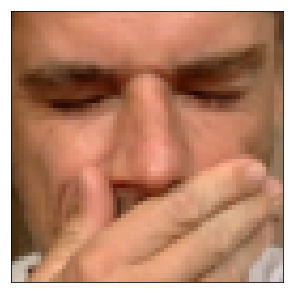

target:blink
pred  :center


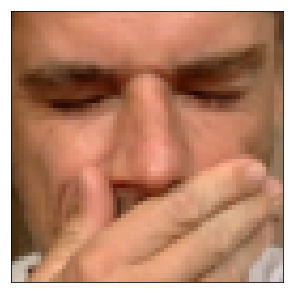

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

for data, labels in ml.dataset.test_loader:
    fig, ax = ml.show(only_wrong=True)
    plt.show() 


## cross-validation

In [11]:
args = init(verbose=0, log_interval=0, epochs=20)
from gaze import MetaML
mml = MetaML(args)
Accuracy = mml.protocol(args, 42)
print('Accuracy', Accuracy[:-1].mean(), '+/-', Accuracy[:-1].std())

Accuracy 0.9418539325842696 +/- 0.009612325074308259


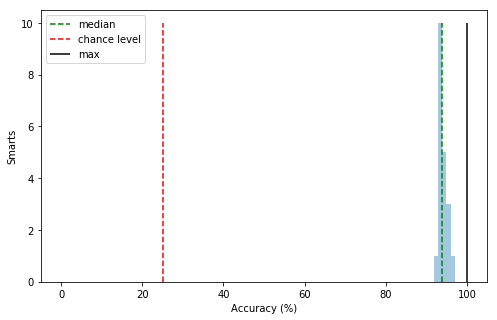

In [32]:
import numpy as np
fig, ax = plt.subplots(figsize=((8, 5)))
n, bins, patches = ax.hist(Accuracy[:-1]*100, bins=np.linspace(0, 100, 100), alpha=.4)
ax.vlines(np.median(Accuracy[:-1])*100, 0, n.max(), 'g', linestyles='dashed', label='median')
ax.vlines(25, 0, n.max(), 'r', linestyles='dashed', label='chance level')
ax.vlines(100, 0, n.max(), 'k', label='max')
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Smarts')
ax.legend(loc='best')
plt.show() 